In [1]:
from matplotlib import cm
from rasterio import plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
watercourses = gpd.read_file('../../../FloodModelling/ExtraData/Watercourses/WatercourseLink.shp')

In [3]:
ld_dict = {'name':'LinDyke',
              'name_str':'Resampled.Terrain',
           'shpfile_name':'CatchmentLinDyke_exported',
              "centre_location" : [53.768306874761016, -1.3756056884868098],}
wb_dict = {'name':'WykeBeck',
          'name_str':'Terrain.wykeDEM',
           'shpfile_name':'WykeBeckCatchment',
          "centre_location" : [53.81001289603593, -1.483594591196338]}

idealised_dict = {'most_extreme':'6h_sp_bl_0.9', 'least_extreme':"6h_sp_fl_0.1"}        
observed_dict = {'most_extreme':'6h_c5', 'least_extreme':"6h_c8"}       
sp_dict = {'most_extreme':'6h_sp_+0%', 'least_extreme':"6h_sp_+20%"}   

In [4]:
def find_cells_flooded_in_one_extreme(catchment_dict, methods_dict, variable_name, method_name):
    
    # Find the catchment shapefile
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
        
    # Read in data
    most_extreme = rxr.open_rasterio(model_directory+ f"{methods_dict['most_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    least_extreme = rxr.open_rasterio(model_directory+ f"{ methods_dict['least_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    
    most_extreme = np.where((most_extreme > 0.1), most_extreme, np.nan)
    
    out_meta = rasterio.open(model_directory+ f"{methods_dict['most_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif").meta.copy()
    # Save
    save_array_as_raster(most_extreme, model_directory + f"CalculatedLayers/MostExtreme_no0.1m_{variable_name}_{method_name}.tif", out_meta) 
    

In [5]:
def find_cells_flooded_in_one_extreme(catchment_dict, methods_dict, variable_name, method_name):
    
    # Find the catchment shapefile
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
        
    # Read in data
    most_extreme = rxr.open_rasterio(model_directory+ f"{methods_dict['most_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    least_extreme = rxr.open_rasterio(model_directory+ f"{ methods_dict['least_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    
    # Make versions where any flooded cell (over 0.1m) has a 1, and others have a np.nan
    most_extreme = np.where((np.isnan(most_extreme)), np.nan, 
                      np.where((most_extreme > 0.01), 1, np.nan))
    least_extreme = np.where((np.isnan(least_extreme)), np.nan, 
                      np.where((least_extreme > 0.01), 1, np.nan))
    
    # Label each cell according to whether it has flooding in neither scenario, both scenarios or 1 or the other
          # Flooded in neither scenario
    new = np.where((np.isnan(most_extreme)& np.isnan(least_extreme)), np.nan, 
            # 0 = flooded in both scenarios (over 0.1m)
            np.where(((least_extreme ==1) & (most_extreme ==1)), 0,
                # 1 = flooded in most_extreme, but not least_extreme
                np.where(((most_extreme ==1) & (least_extreme ==0)), 1,
                np.where(((most_extreme ==1) & np.isnan(least_extreme)), 1,             
                    # 2 = flooded in least_extreme, but not most_extreme
                    np.where(((least_extreme ==1) & (most_extreme ==0)), 2 ,
                    np.where(((least_extreme ==1) & np.isnan(most_extreme)), 2 ,                 
                        # 500 = any other cells (shouldn't be any)        
                         600))))))
        
    # Get out meta for proper saving
    out_meta = rasterio.open(model_directory+ f"{methods_dict['most_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif").meta.copy()
    # Save
    save_array_as_raster(new, model_directory + f"CalculatedLayers/FloodedMostExtremeOnly_{variable_name}_{method_name}.tif", out_meta) 

In [6]:
find_cells_flooded_in_one_extreme(wb_dict, idealised_dict ,'Depth','Idealised')
# find_cells_flooded_in_one_extreme(ld_dict, observed_dict, 'Depth','Observed')

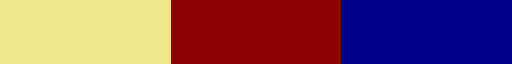

In [7]:
cmaplist = ['khaki', 'darkred', 'darkblue']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist,3)
cmap

In [8]:
catchment_dict=wb_dict
method_name='Idealised'
variable_name='Depth'
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
fp = model_directory + f"CalculatedLayers/FloodedMostExtremeOnly_{variable_name}_{method_name}.tif"

#######################################
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
catchment_gdf = gpd.read_file(catchment_shp)

watercourses_clip = gpd.clip(watercourses, catchment_gdf)

In [ ]:
import earthpy.spatial as es
from rasterio.plot import plotting_extent
import earthpy.plot as ep

fp = model_directory + f"CalculatedLayers/FloodedMostExtremeOnly_{variable_name}_{method_name}.tif"
fig, axs = plt.subplots(ncols=1, figsize=(40, 40))
#################################################################
# Read in and prepare data
#################################################################
# # Read in shapefile for use in cropping
# with rasterio.open(fp) as raster_crs:
#     # Get crs to read in the catchment shape file
#     crop_raster_profile = raster_crs.profile
#     crop_bound_utm13N = catchment_gdf.to_crs(crop_raster_profile["crs"])    

# watercourses_clip.to_crs(crop_raster_profile["crs"])  

# Read in raster data amd crop to the shapefile
with rasterio.open(fp) as src:
    single_cropped_image, single_cropped_meta = es.crop_image(src, catchment_gdf)
    #single_cropped_image = np.ma.masked_array(single_cropped_image, single_cropped_image < 0)
    
# Create the extent object for plotting
single_crop_extent = plotting_extent(single_cropped_image[0], single_cropped_meta["transform"])

# cx.add_basemap(axs, crs = catchment_gdf.crs.to_string(),
#                url =cx.providers.OpenStreetMap.Mapnik,zoom="auto",alpha=0.2)    

#################################################################
# Mask array if necessary (in this case this is for the terrain data)
#################################################################
# # For landcover plot
# if colors != None:
#     # Mask array (don't want to include values of 0, as these are no data values here)
#     single_cropped_image = np.ma.masked_array(single_cropped_image[0], single_cropped_image[0] < 0.001)
#     # Define a vmin and vmax (so it uses the values for this plot)
#     vmin = np.nanmin(single_cropped_image)
#     vmax = np.nanmax(single_cropped_image)

# For terrain plot
# Define a vmin and vmax (so it's consistent across the plots)
vmin = 0
vmax = 3


# And set up the legend object
patches_list = []
labels = ['Both', 'BL only', 'FL only']
for i, color in  enumerate(cmaplist):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  
axs.legend(handles=patches_list, handleheight=2, handlelength=2, fontsize =20);

#################################################################
# Plot the image
#################################################################
# crop_bound_utm13N.boundary.plot(ax=axs, color="black", zorder=10)
ep.plot_bands(single_cropped_image, ax=axs, cmap = cmap, 
                  vmin=vmin,vmax=vmax,extent=single_crop_extent,cbar=False)


catchment_gdf.plot(ax=axs, facecolor="none", linewidth=3, edgecolor = 'black')
watercourses_clip.plot(ax=axs, facecolor="none", linewidth=2, edgecolor = 'blue')

fig.savefig("Outputs/Figs/IdealisedProfiles/LinDyke/earthpy.jpg", dpi=300)    

In [12]:
def find_difference_between_extremes(catchment_dict, methods_dict, variable_name, method_name):
    
    # Find the catchment shapefile
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
   
    # Find the string for this method, which relate to the two most different scenarios
    most_extreme_str = methods_dict["most_extreme"]
    least_extreme_str = methods_dict["least_extreme"]
        
    # Read in data
    most_extreme = rxr.open_rasterio(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    least_extreme = rxr.open_rasterio(model_directory+ f"{least_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif",masked=True).squeeze()
    
    # Set any NA values to 0, where the other scenario doesn't have an NaN
    # This allows the difference to be counted for cells which have an NaN in one but not the other
    most_extreme.data[np.isnan(most_extreme.data) & (~np.isnan(least_extreme.data))] = 0
    least_extreme.data[np.isnan(least_extreme.data) & (~np.isnan(most_extreme.data))] = 0
    
    # Find the difference and save
    diff= most_extreme -least_extreme
    
    # Get out meta for proper saving
    out_meta = rasterio.open(model_directory+ f"{most_extreme_str}/{variable_name} (Max).{catchment_dict['name_str']}.tif").meta.copy()
    save_array_as_raster(diff, model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif", out_meta) 

    # Find difference as either a positive or a negative
    pos_neg_depth_diff = np.where((np.isnan(diff)), np.nan, 
                          np.where((diff < 0), 0,
                            np.where((diff == 0), 1,
                                np.where((diff > 0), 2, 500))))
    save_array_as_raster(pos_neg_depth_diff, 
                         model_directory + f"CalculatedLayers/PosNegDifferencesBetweenExtremes_{variable_name}_{method_name}.tif", out_meta) 
    
    
def plot_difference_between_extremes(catchment_dict, variable_name, method_name, ax,add_basemap= True, add_colorbar= False):
    #######################################
    # Read in catchment shapefile
    #######################################
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
    print(catchment_gdf.crs.to_string())
    
    #######################################
    # Define colormap
    #######################################
    cmap = mpl.cm.RdYlGn.copy()
    #cmap.set_bad('purple', 1.)
        
    #######################################
    # Plot catchment boundary and basemap
    #######################################
    catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor = 'black')
    if add_basemap == True:
        cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.Stamen.Watercolor,alpha=0.2)
    
    #######################################
    # Read in data and add to map
    #######################################
    fp = model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif"
    
    with rasterio.open(fp) as src:
        #array = src.read(1)
        image = plot.show(src, ax=ax,  cmap=cmap,  vmin=-0.1,  vmax=0.1)

    #######################################
    # Format
    #######################################
    #ax.axis('off')
    ax.set_title(method_name, fontsize =20)
    
    # Colorbar creation
    if add_colorbar == True:  
        if add_basemap == True:
            im = image.get_images()[1]
        else:
            im = image.get_images()[0]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="8%", pad=0.09)
        cbar  = fig.colorbar(im, cax)
        
        cbar.ax.tick_params(labelsize=50)

# THIS IS THE ONE

EPSG:27700


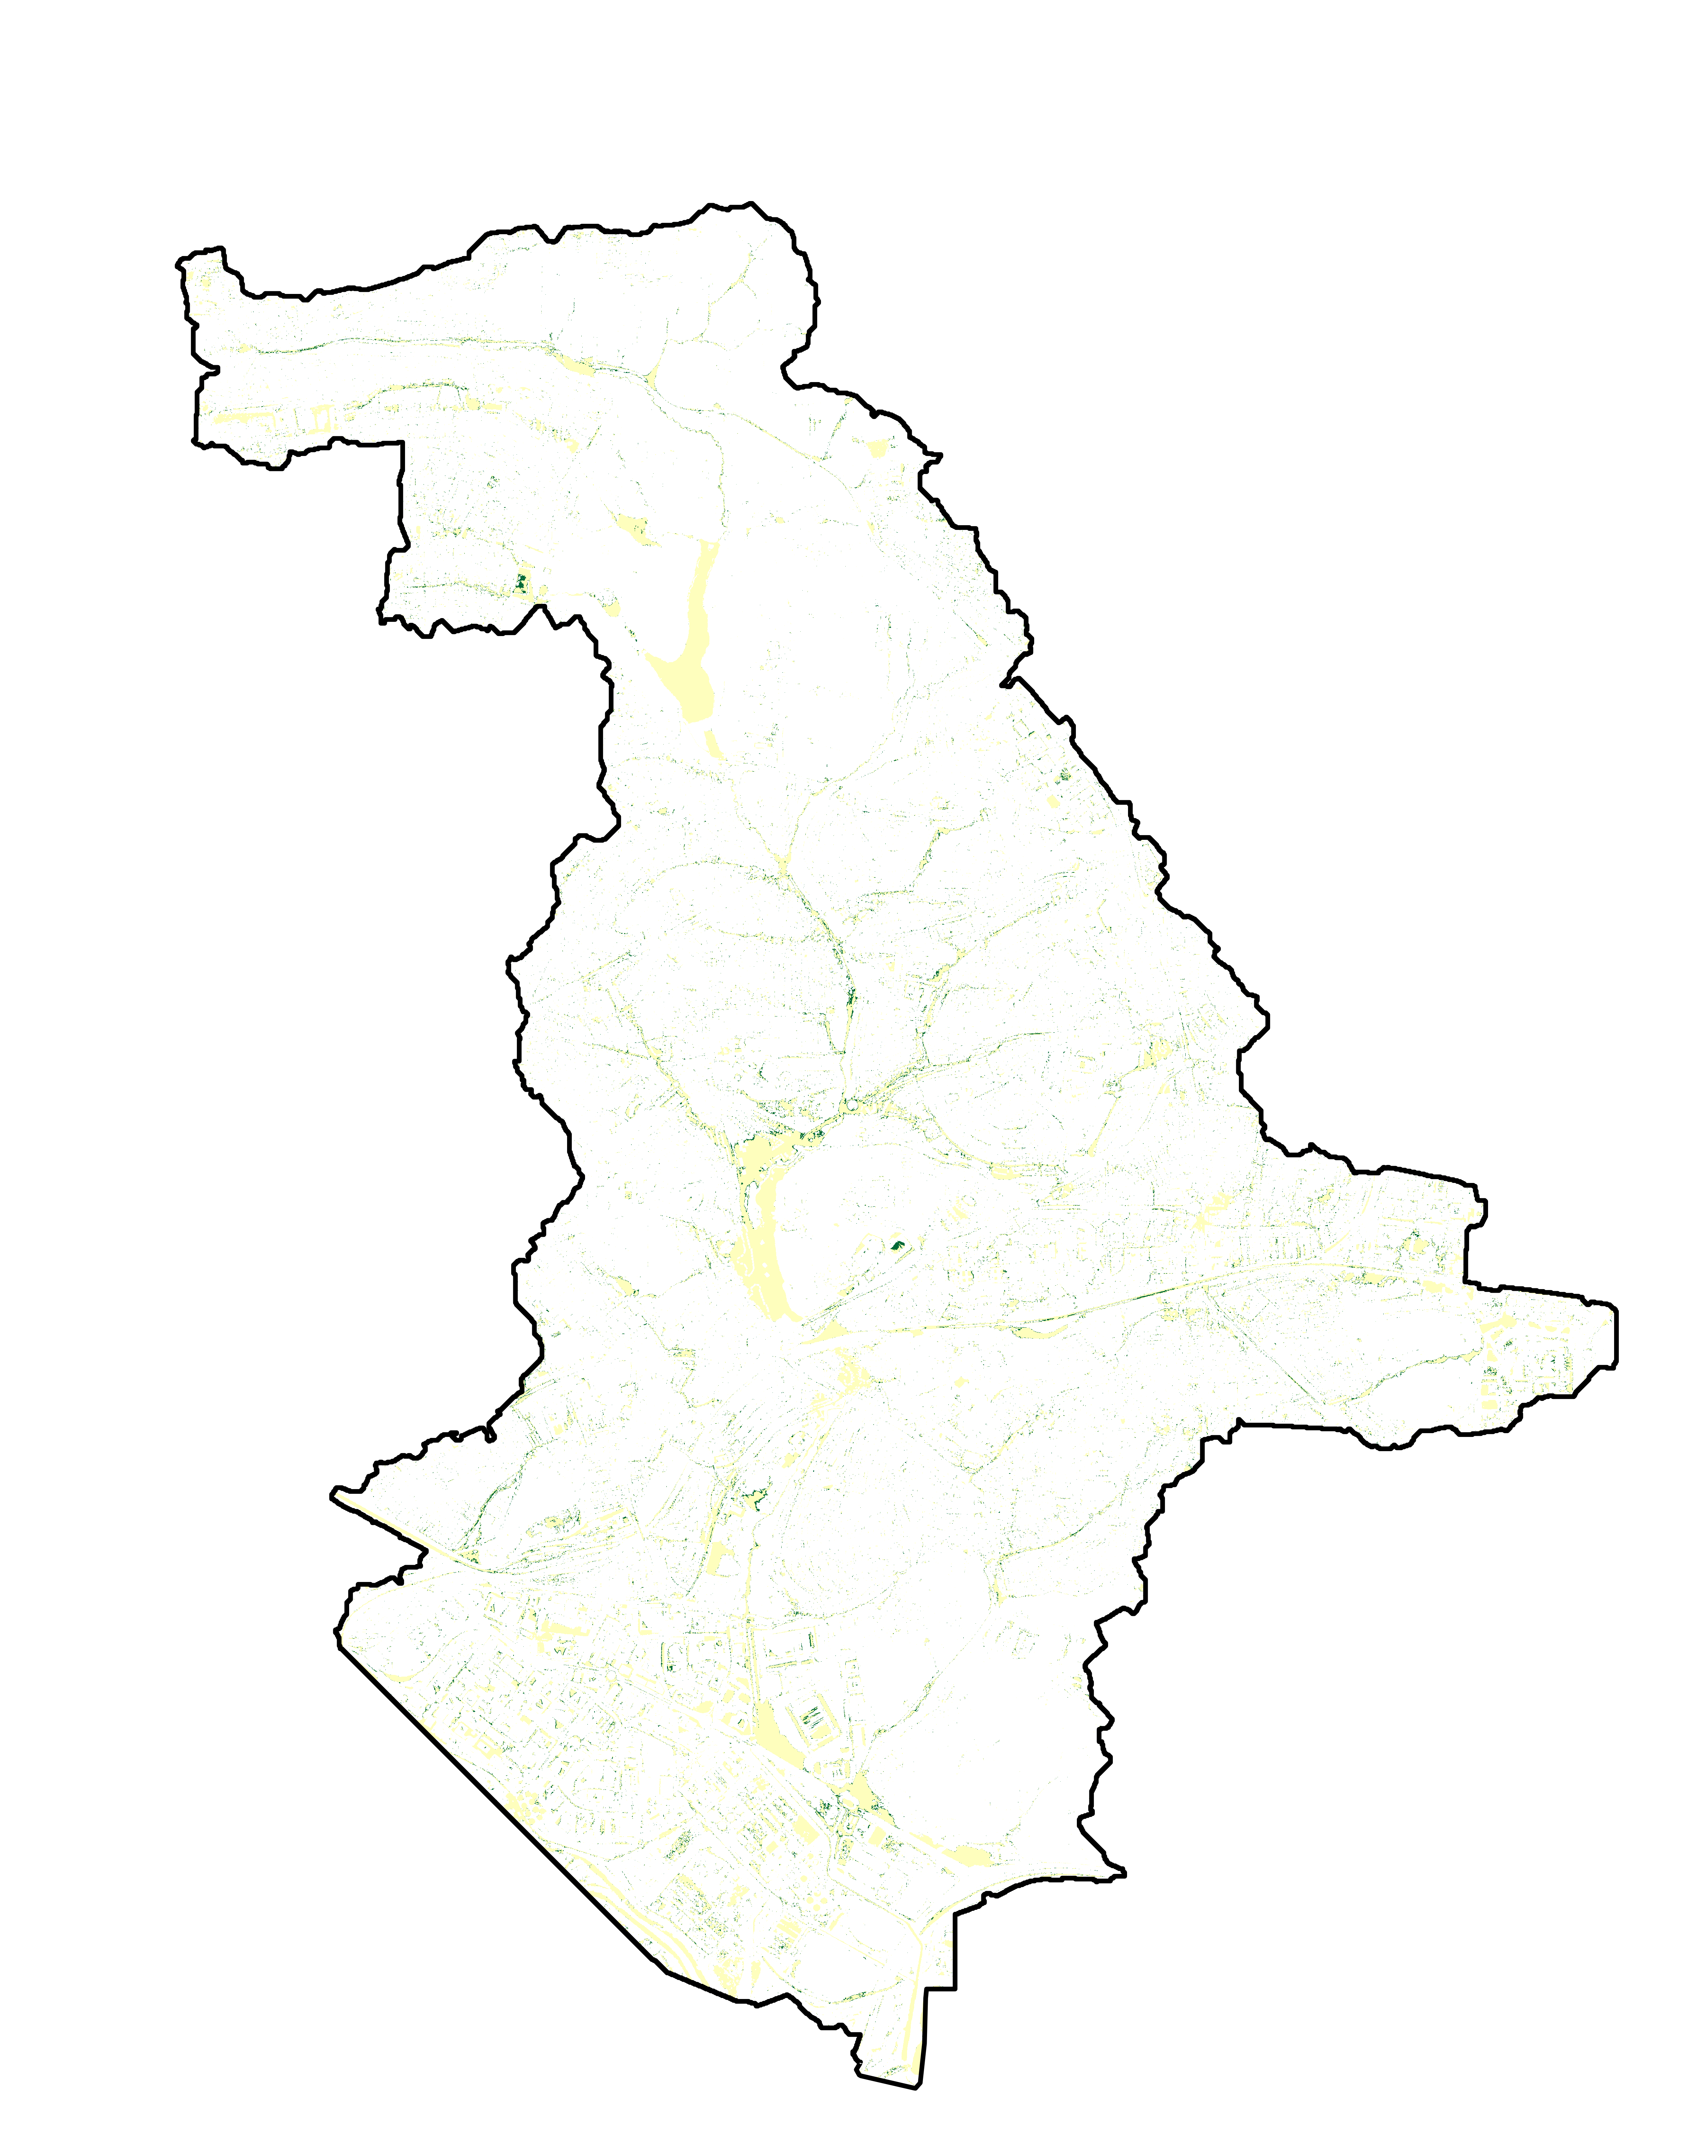

In [39]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=1000)
add_colorbar = False
add_basemap= False

#######################################
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
catchment_gdf = gpd.read_file(catchment_shp)
print(catchment_gdf.crs.to_string())

#######################################
# Define colormap
#######################################
cmap = mpl.cm.RdYlGn.copy()
#cmap.set_bad('purple', 1.)

#######################################
# Plot catchment boundary and basemap
#######################################
catchment_gdf.plot(ax=ax, facecolor="none", linewidth=1, edgecolor = 'black')
if add_basemap == True:
    cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.Stamen.Watercolor,alpha=0.2)

#######################################
# Read in data and add to map
#######################################
with rasterio.open(fp) as src:
    #array = src.read(1)
    image = plot.show(src, ax=ax,  cmap=cmap,  vmin=-0.1,  vmax=0.1)

#######################################
# Format
#######################################
ax.axis('off')
#ax.set_title(method_name, fontsize =20)

# Colorbar creation
if add_colorbar == True:  
    if add_basemap == True:
        im = image.get_images()[1]
    else:
        im = image.get_images()[0]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.09)
    cbar  = fig.colorbar(im, cax)

    cbar.ax.tick_params(labelsize=20)
    
plt.savefig('output2.png', bbox_inches='tight', pad_inches=0.1)    

# Actually maybe this is the one

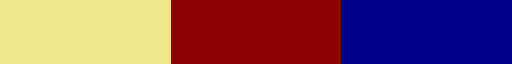

In [42]:
cmaplist = ['khaki', 'darkred', 'darkblue']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist,3)
cmap

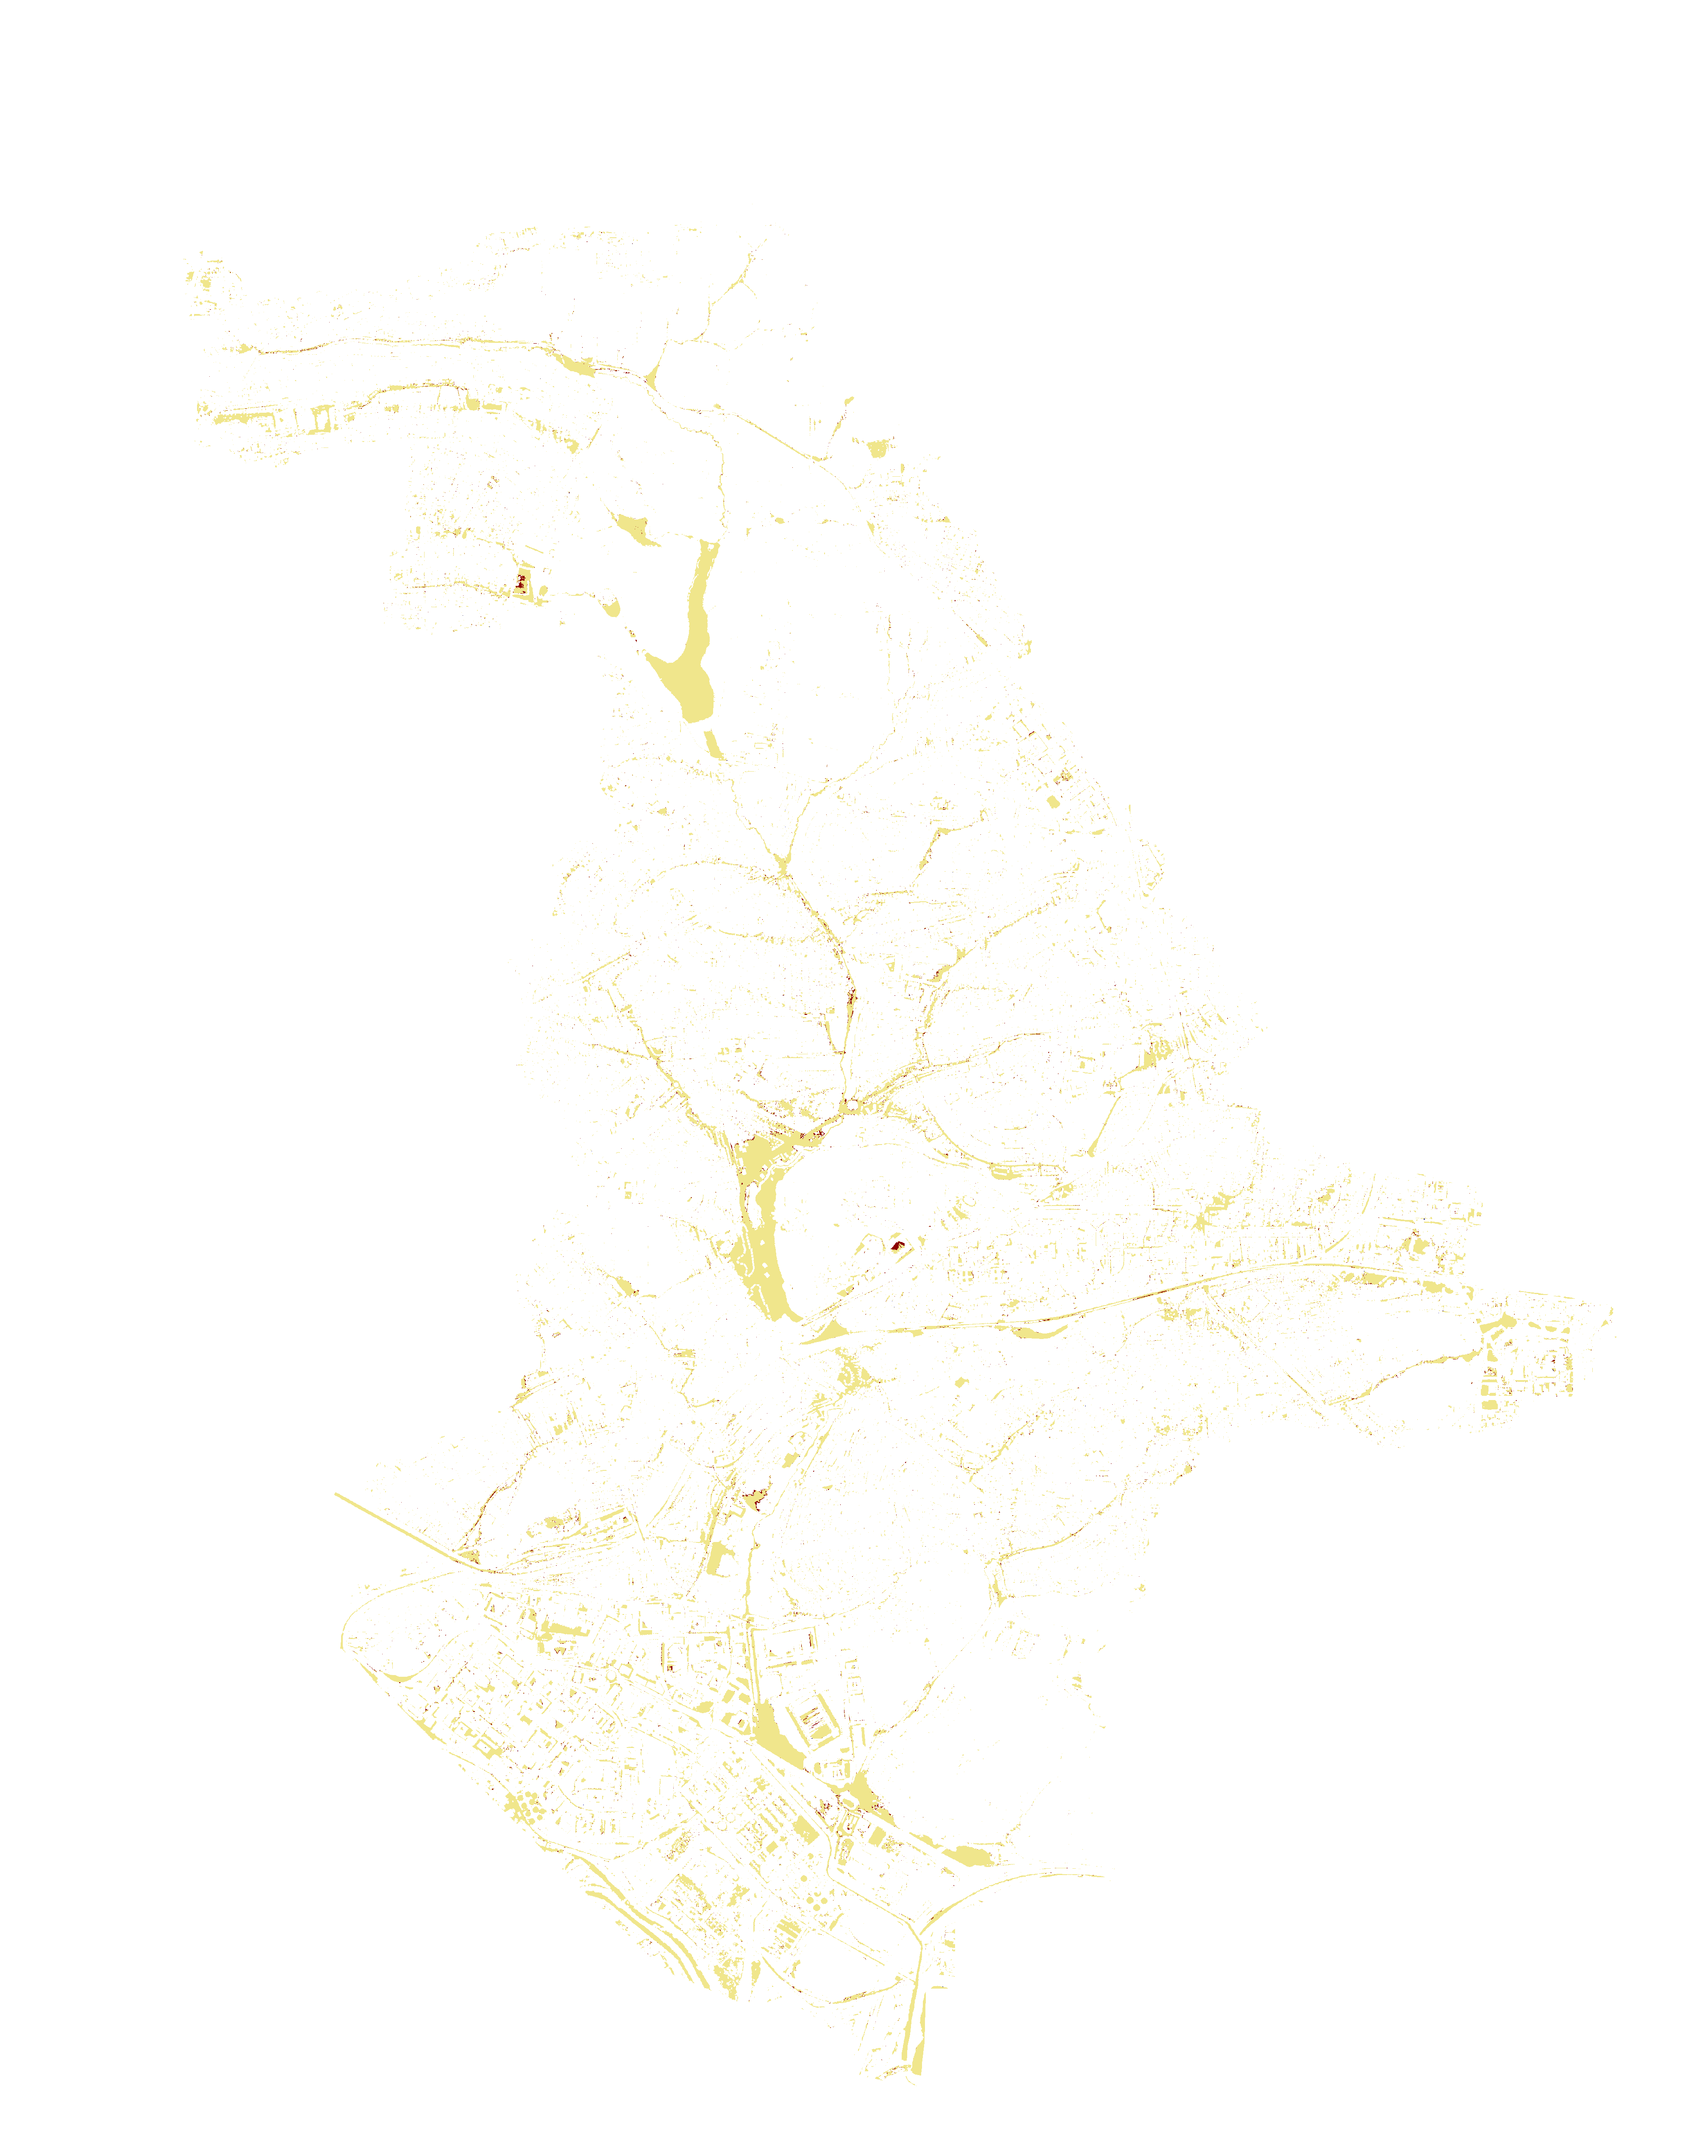

In [44]:
# Open the raster dataset
fp = model_directory + f"CalculatedLayers/FloodedMostExtremeOnly_{variable_name}_{method_name}.tif"
dataset = rasterio.open(fp)

# Read the raster data
data = dataset.read(1)  # Change the band number (e.g., 1, 2, 3) based on your data

# Set up the figure size and DPI
fig, ax = plt.subplots(figsize=(8, 8), dpi=800)

# Display the raster data using rasterio.plot.show
show(data, cmap=cmap, ax=ax)

#catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor = 'black')

ax.axis('off')
# Save the figure to a file (e.g., PNG)
plt.savefig('output.png', bbox_inches='tight', pad_inches=0.1)

### Find difference

In [99]:
find_difference_between_extremes(wb_dict, idealised_dict, 'Depth', 'Idealised')
find_difference_between_extremes(wb_dict,  observed_dict, 'Depth', 'Observed')

find_difference_between_extremes(ld_dict, idealised_dict,'Depth', 'Idealised')
find_difference_between_extremes(ld_dict, observed_dict, 'Depth','Observed')

find_difference_between_extremes(wb_dict, idealised_dict ,'Velocity','Idealised')
find_difference_between_extremes(wb_dict, observed_dict ,'Velocity','Observed')

find_difference_between_extremes(ld_dict, idealised_dict ,'Velocity','Idealised')
find_difference_between_extremes(ld_dict, observed_dict, 'Velocity','Observed')

In [77]:
find_cells_flooded_in_one_extreme(ld_dict, idealised_dict ,'Depth','Idealised')
find_cells_flooded_in_one_extreme(ld_dict, observed_dict, 'Depth','Observed')

In [22]:
# fig, axs = plt.subplots(figsize=(8, 8), dpi=1000)
# plot_difference_between_extremes(ld_dict, 'Depth', 'Idealised', axs, True, True)
# fig.savefig("Outputs/Figs/IdealisedProfiles/LinDyke/IP_LD_Diff.jpg")

In [23]:
# fig, axs = plt.subplots(ncols=1, figsize=(80, 40))
# plot_difference_between_extremes(wb_dict, 'Depth', 'Idealised', axs, True, True)

In [237]:
# fig, axs = plt.subplots(ncols=1, figsize=(80, 40))
# plot_difference_between_extremes(wb_dict, 'Depth', 'Idealised', axs, True, True)
# # plot_difference_between_extremes(wb_dict, 'Depth', 'Observed', axs[1], False, True)

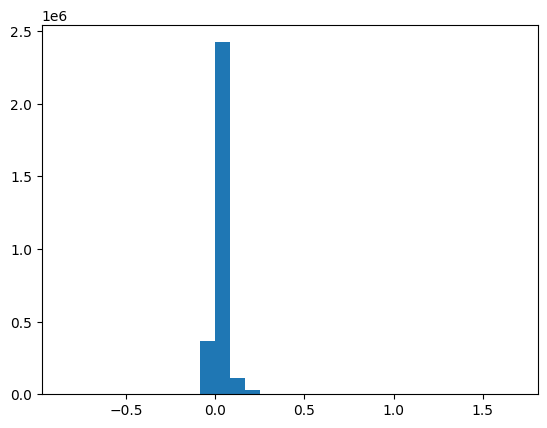

In [135]:
import pylab
pylab.hist(diff.data[~np.isnan(diff.data)],bins=30);

In [221]:
def colorize(array, cmap, vmin, vmax):
    cm = plt.cm.get_cmap(cmap)    
    if np.nanmin(array) == np.nanmax(array):
        return np.uint8(cm(array)  * 255)
    else:
        normed_data = (array - vmin) / (vmax - vmin) 
        # normed_data = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array)) 
        return np.uint8(cm(normed_data)  * 255)

def folium_baseplot(catchment_dict, method_name):
    
    model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    catchment_shp = model_directory + "{}.shp".format(catchment_dict["shpfile_name"])
    catchment_gdf = gpd.read_file(catchment_shp)
    
    # Set up figure
    f = folium.Figure(width=1000, height=1000)

    # Create base map - location figures were from clat, clon, but wanted to create map before loop
    mapa = folium.Map(location=catchment_dict['centre_location'],zoom_start=13,tiles ='cartodb positron').add_to(f)
    folium.TileLayer(tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
        attr="No Base Map",name="No Base Map",show=True).add_to(mapa)

    # Catchment boundary
    catchment_boundary_feature_group = FeatureGroup(name=catchment_dict['name'])
    catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                         fillColor='#00000000', color='green': { "fillColor": '#00000000',"color": 'Black',}))
    mapa.add_child(catchment_boundary_feature_group)
        
    return mapa

def add_folium_layer(mapa, fp, layername):

    ###########################################
    # Read in data
    ###########################################
    with rasterio.open(fp) as src:
        array = src.read(1)
    layer=prep_for_folium_plotting (fp)
    
    ###########################################
    # Get coordinates needed in plotting
    ###########################################
    clat, clon = layer.y.values.mean(), layer.x.values.mean()
    mlat, mlon = layer.y.values.min(), layer.x.values.min()
    xlat, xlon = layer.y.values.max(), layer.x.values.max()
    
    ###########################################
    #  Add to feature group
    ###########################################
    data  = ma.masked_invalid(layer)
    colored_data = colorize(data.data, cmap='RdYlGn', vmin = -0.1,vmax= 0.1)
    feature_group = FeatureGroup(name=layername)
    feature_group.add_child(folium.raster_layers.ImageOverlay(colored_data,[[mlat, mlon], [xlat, xlon]],
                              opacity=0.8,interactive=True, popup='Test'))
    mapa.add_child(feature_group)
    
    return mapa

def plot_with_folium(catchment_dict, variable_name, method_name, fps_and_names):
    
    # Create basemap
    mapa = folium_baseplot(catchment_dict, method_name)
    
    # Get fp of layer to add to map
    for name, fp  in fps_and_names.items():
        # Add layer to map 
        mapa = add_folium_layer(mapa, fp, name)
   
    # # Add layers to map
    mapa.add_child(LayerControl("topright", collapsed = False))
    # Display the map
    display(mapa)
    img_data = mapa._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    img.save("Outputs/Figs/IdealisedProfiles/LinDyke/test.png")
    
    return mapa

/tmp/ipykernel_351611/2636033665.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap(cmap)



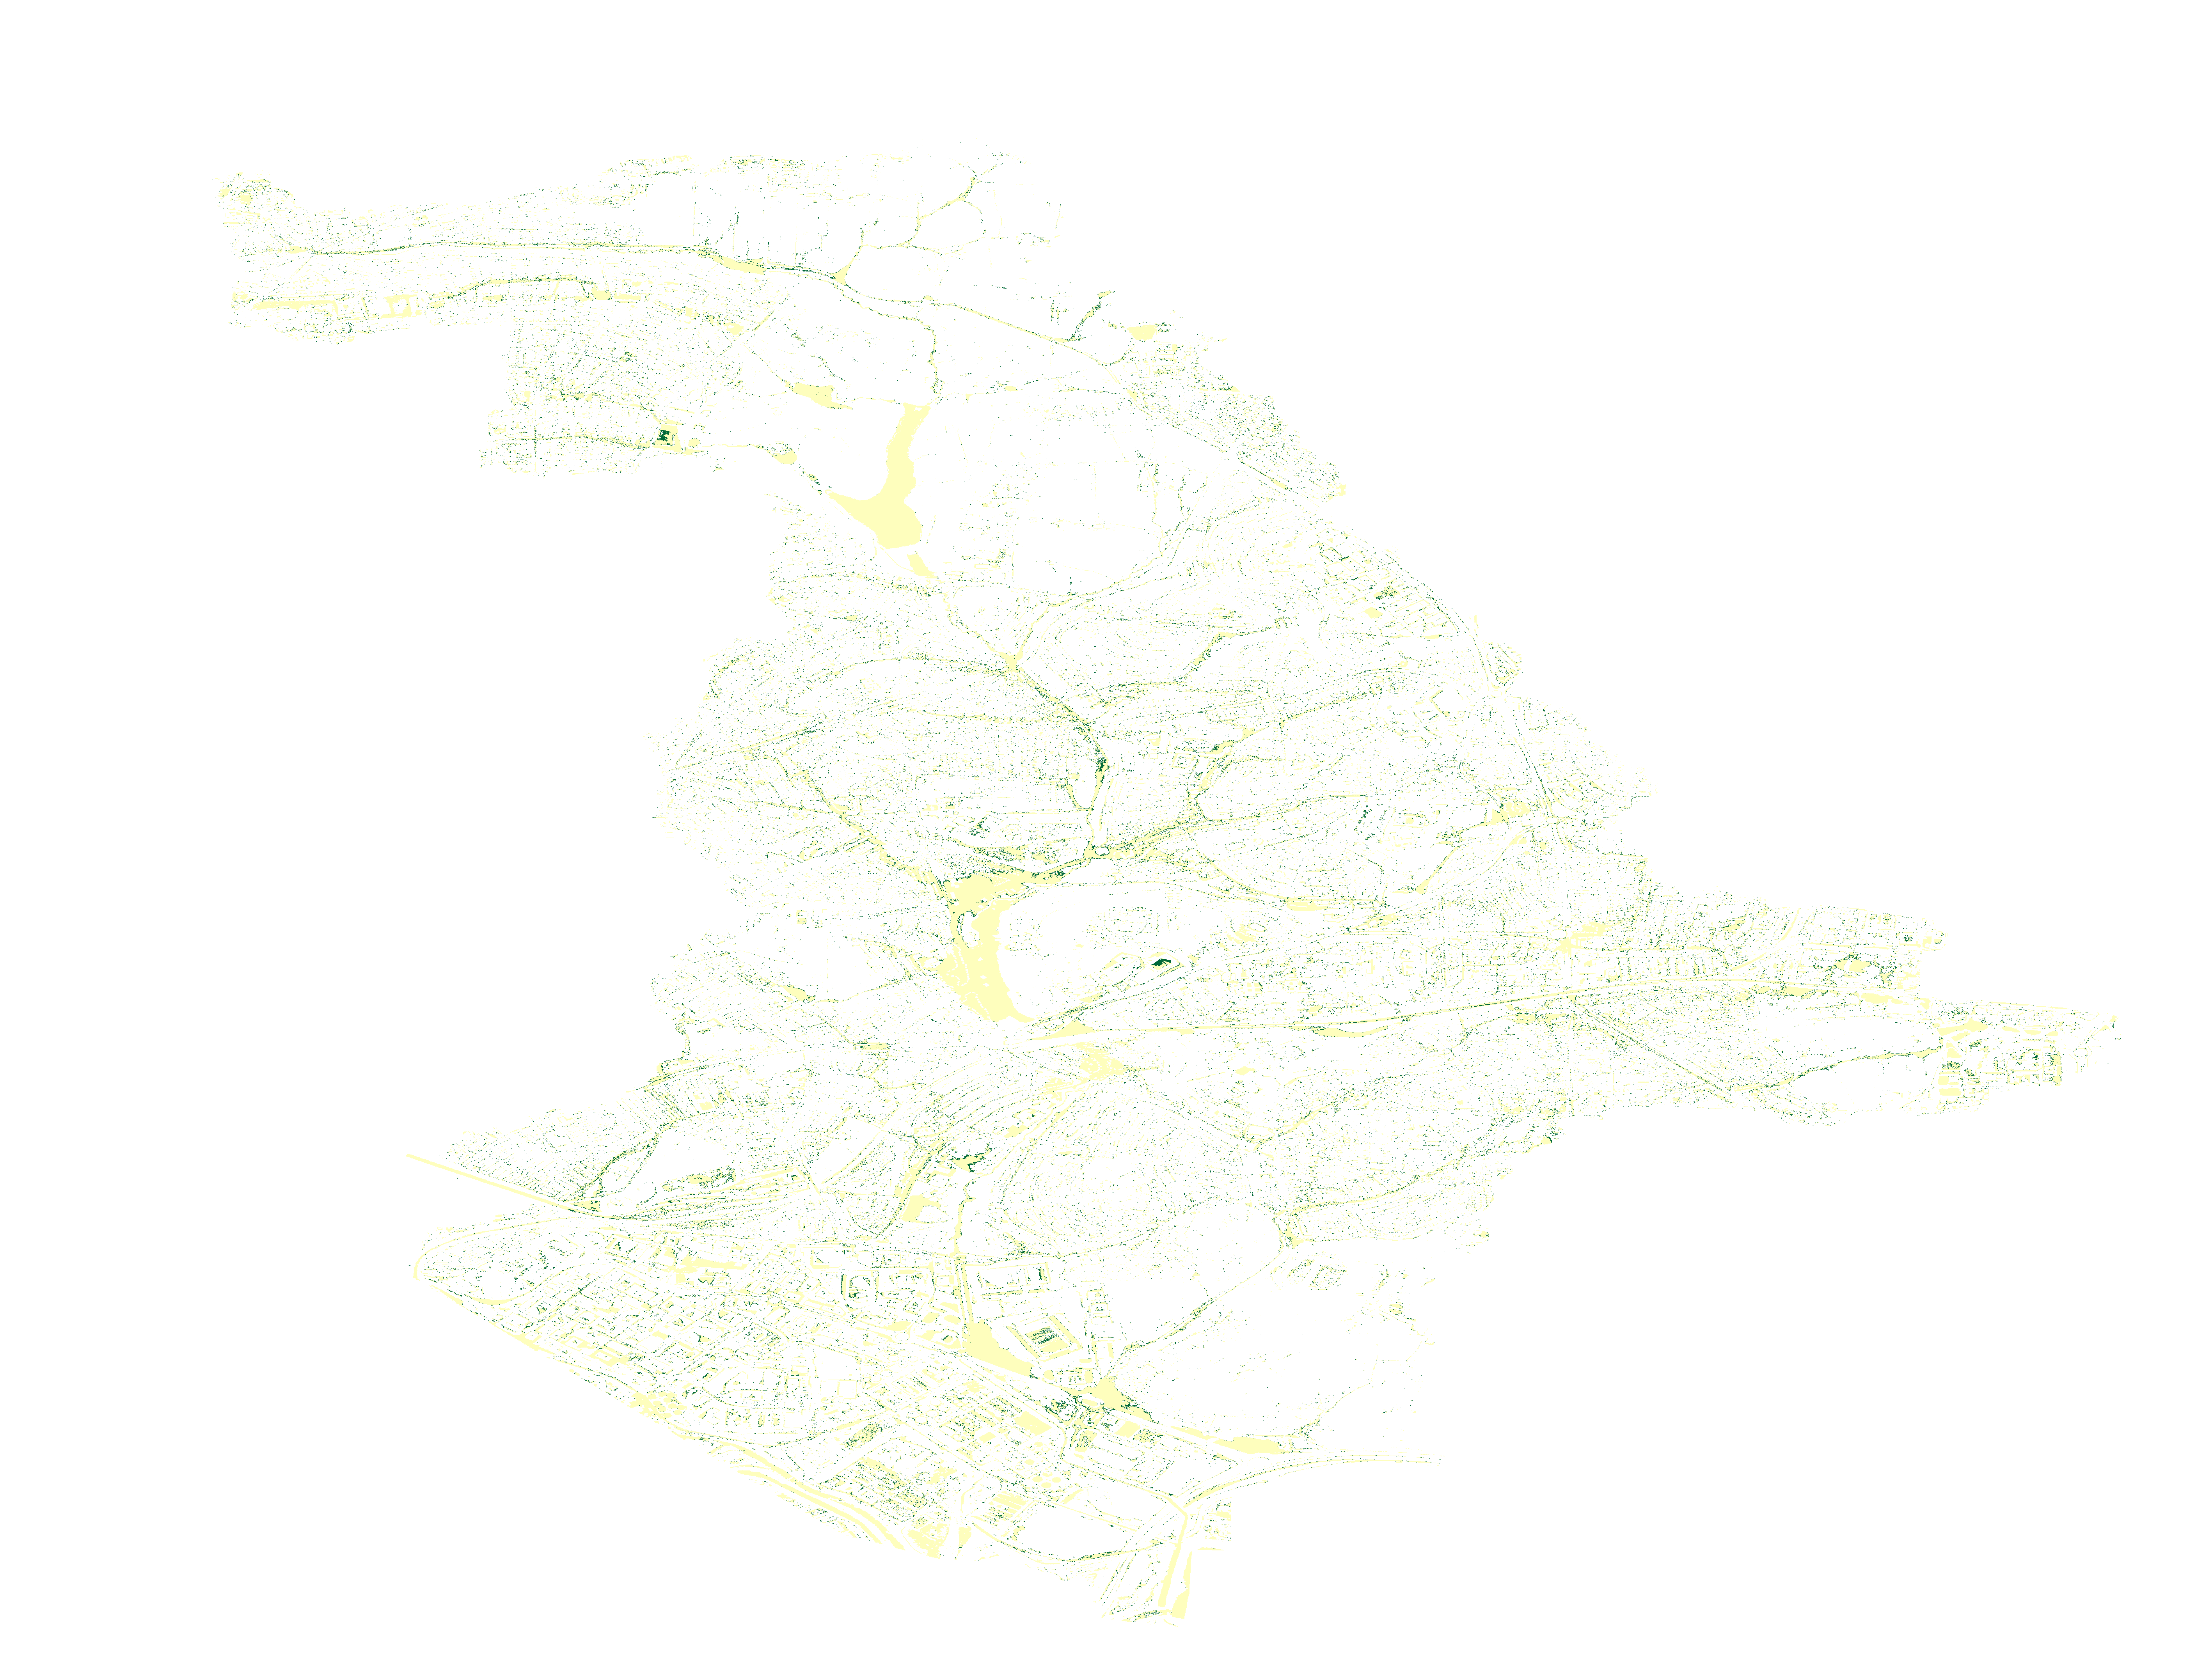

In [231]:
method_name = 'Idealised'
methods_dict = idealised_dict
variable_name ='Depth'
catchment_dict = wb_dict
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles/'.format(catchment_dict['name'], method_name)
    
fps_and_names = {#'diff':model_directory + f"CalculatedLayers/DifferencesBetweenExtremes_{variable_name}_{method_name}.tif",
'difference':model_directory + f"CalculatedLayers/FloodedMostExtremeOnly_{variable_name}_{method_name}.tif",                 
#         'posnegdiff':model_directory + f"CalculatedLayers/PosNegDifferencesBetweenExtremes_{variable_name}_{method_name}.tif",
#                 'most_extreme':model_directory+ f"{methods_dict['most_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",
                # 'least_extreme':model_directory+ f"{methods_dict['least_extreme']}/{variable_name} (Max).{catchment_dict['name_str']}.tif",
                }

mapa = plot_with_folium(wb_dict, 'Depth', 'Idealised', fps_and_names)

In [230]:
# Open fire boundary data with geopandas
catchment_boundary = gpd.read_file(fire_boundary_path)